In [73]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams 


import gensim
from collections import Counter, defaultdict
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from typing import List, Dict, Set, Tuple, Callable, Iterable
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns


## Introduction 

### The Myers-Briggs Type Indicator (MBTI)

Myers-Briggs Type Indicator (MBTI) is a self-report questionnaire that permits to classify people into 16 psychological types. The types are derived from Jung personality theory, and represent some sort of archetypes.

Types are defined by four dichotomies (pairs of opposite traits):

- **E**xtraversion (E) vs **I**ntroversion (I) $\leftarrow$ 
  - are you more internally or externally focused? 
  - Do you gain energy from being around people or from being alone?
- **S**ensing (S) vs i**N**tuition (N) $\leftarrow$ 
  - how do you gather information? 
  - Are you more practical and concrete or more abstract and theoretical?
- **T**hinking (T) vs **F**eeling (F) $\leftarrow$ 
  - how do you make decisions? 
  - Are you more rational (detached, reasonable, logical) or more emotional (empathetic, compassionate, sensitive, involved from inside)?
- **J**udging (J) vs **P**erceiving (P) $\leftarrow$ (a bit more tricky) 
  - it is a sort of lifestyle preference. 
  - Do you prefer to show externally your main perceiving function (sensing or intuition) or your main judging function (thinking or feeling)? 

$\Rightarrow$ combining those four dichotomies, you obtain 16 types, each one with a specific combination of traits. Each type is identified by four letters. Some examples:

> *"ENFP"* $\leftarrow$ Extraverted, iNtuitive, Feeler, who prefers do display his perceiving function (iNtuition).
> 
> *"ISTJ"* $\leftarrow$ Introverted, Sensor, Thinker, who prefers to display his judging function (Thinking).

Moreover, each type has been labelled with an "archetipal" name. For example, the ENFP type is called "The Campaigner", and the ISTJ type is called "The Logistician", etc.


### Further ideas and criticisms 

- there is a whole theory about the cognitive functions, differences between original Jung theory and MBTI, correlation with other indicators, etc.
- there is also a lot of criticism on validity and reliability of the test...
  - not all the theory is not based on scientific evidence
  - there is few evidence of the existence of some traits and some other traits seems not to be so dichotomous
  - "non predictive" nature of the test
  - business and companies born around the test
  - etc.

Some sources:

- Wikipedia: https://en.wikipedia.org/wiki/Myers%E2%80%93Briggs_Type_Indicator
- The 16 personalities descriptions and the main test website: https://www.16personalities.com/personality-types 

### What we do in this project

In this project we take the descriptions of the 16 types and we try to extract some information from them, using various NLP techniques.

## The dataset

- Source: https://www.kaggle.com/datasets/yamaerenay/mbtitypes-full?select=types.csv 
  - (it contains the descriptions of the main website, grouped in a single CSV table)
- For each type, we have
  - the four letters dichotomy
  - the archetipal name (nickname)
  - various descriptions of different aspects of the type (e.g. "strengths", "weaknesses", "romantic relationships", etc.)

### Data gathering

You can download the CSV dataset from the [link above](https://www.kaggle.com/datasets/yamaerenay/mbtitypes-full?select=types.csv). To begin the analysis, extract eventual ZIPs and put the `types.csv` file it in the `./data/` folder.

In [74]:
types = pd.read_csv('data/types.csv')
types.set_index('Type', inplace=True)

In [75]:
types.head(1)

,Introduction,Strengths and Weaknesses,Romantic Relationships,Friendships,Parenthood,Career Paths,Workplace Habits,Conclusion,Celebrities,Description,Nickname,Definition,E,I,N,S,T,F,J,P
Type,,,,,,,,,,,,,,,,,,,,
INTJ,Introduction\n\nWHO IS AN ARCHITECT (INTJ)?\n\...,Strengths & Weaknesses\nArchitect (INTJ) Stren...,Romantic Relationships\n\n“Of all forms of cau...,Friendships\n\n“A friend to all is a friend to...,Parenthood\n\n“Children must be taught how to ...,Career Paths\n\n“One never notices what has be...,Workplace Habits\n\nWhat Architects (INTJs) wa...,Conclusion\n\n“No escape from patterns and sys...,"['Friedrich Nietzsche', 'Michelle Obama', 'Elo...","Imaginative and strategic thinkers, with a pla...",Architect,An Architect (INTJ) is a person with the Intro...,0,1,1,0,1,0,1,0


In [76]:
types.columns

Index(['Introduction', 'Strengths and Weaknesses', 'Romantic Relationships',
       'Friendships', 'Parenthood', 'Career Paths', 'Workplace Habits',
       'Conclusion', 'Celebrities', 'Description', 'Nickname', 'Definition',
       'E', 'I', 'N', 'S', 'T', 'F', 'J', 'P'],
      dtype='object')

We bring the data into two formats:

- format 1: a single Pandas `DataFrame`, with one row foreach type and single corpus column containing all the sections merged together
- format 2: a Pandas `DataFrame` with one row for each tuple `(type, section)` and a corpus column containing the text of the section

In [77]:
# ------------------------------
# generate format 1: 

# columns to be used for corpus
corpus_cols = [
    'Description', 'Introduction', 'Strengths and Weaknesses',
    'Romantic Relationships', 'Friendships', 'Parenthood',
    'Career Paths', 'Workplace Habits', 'Conclusion'
]

# generate a single description for each type
df_types_ft = pd.DataFrame()
df_types_ft['corpus'] = types.apply(
    lambda row: "\n\n".join(row[corpus_cols]), axis=1
    )
df_types_ft.head(5)

,corpus
Type,
INTJ,"Imaginative and strategic thinkers, with a pla..."
INTP,Innovative inventors with an unquenchable thir...
ENTJ,"Bold, imaginative and strong-willed leaders, a..."
ENTP,Smart and curious thinkers who cannot resist a...
INFJ,"Quiet and mystical, yet very inspiring and tir..."


In [78]:
# get average nr. of words in each full-text corpus

print(
    "Average nr. of words in each full-text corpus:\t", 
    np.mean(df_types_ft['corpus'].apply(lambda x: len(x.split())))
    )


Average nr. of words in each full-text corpus:	 4144.6875


In [79]:
# generate format 2:

df_types_sects = types.reset_index() \
    .melt(  # turn columns into rows (identified by a 'Type','section' pair)
        id_vars='Type',
        value_vars=corpus_cols, 
        var_name='section', 
        value_name='corpus'
    )

df_types_sects.index = df_types_sects['Type'] + '.' + df_types_sects['section']

df_types_sects.head(5)

,Type,section,corpus
INTJ.Description,INTJ,Description,"Imaginative and strategic thinkers, with a pla..."
INTP.Description,INTP,Description,Innovative inventors with an unquenchable thir...
ENTJ.Description,ENTJ,Description,"Bold, imaginative and strong-willed leaders, a..."
ENTP.Description,ENTP,Description,Smart and curious thinkers who cannot resist a...
INFJ.Description,INFJ,Description,"Quiet and mystical, yet very inspiring and tir..."


In [80]:
# get average nr. of words in each section corpus

print(
    "Average nr. of words in each section corpus:\t", 
    np.mean(df_types_sects['corpus'].apply(lambda x: len(x.split())))
    )

Average nr. of words in each section corpus:	 460.5208333333333


## Summarization

> Which are the main characteristics of each MBTI type? 
> How can we summarize them in few words?

**Tools and techniques**: *sencence scoring based summarization, TF-IDF*

**What we will do**:

- preprocessing: 
  - to lower-case
  - tokenization
  - stop words and punctuation removal
    - NOTE: we choose to add the 4 letters and the nickname of the type to the stop words, because they are over-represented in the text and we want to focus on types characteristics more than type names.
  - lemmatization
  - n-grams generation

  (preprocessing is performed on the sections, then it can be )

- build a dictionary w. frequencies
  - (keeping track both about the type and the sections)

- to score sentences, we choose to use TF.IDF (consiedering the type or the section as a document), because it permits us to give more importance to the tokens that are more specific of a type and not the others.

In [81]:
# ------------------------------
# define a preprocessing function

# generate lemmatizer
lemmatizer = WordNetLemmatizer()

# types names are stopwords
types_letters_and_nicknames = [w.lower() for w in list(types.Nickname) + list(types.index)]

def preprocessing(
        text: str, 
        n_ngrams: int = 1, 
        lemmatizer: WordNetLemmatizer = lemmatizer, 
        other_stopwords: List[str] = []
        ) -> List[str]:
    """
    Preprocess text for one document. 

    Applied operations are: to lower case, tokenization, 
    stop words and punctuation removal, 
    lemmatization, n-grams generation
    """
    
    # to lower case and tokenization
    tokens = nltk.word_tokenize(text.lower())

    # stop words and punctuation removal
    tokens = [
        token for token in tokens \
        if token.isalpha() and \
        (token not in nltk.corpus.stopwords.words('english')) and \
        (token not in other_stopwords)
        ]

    # lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    if n_ngrams <= 1:
        return tokens
    
    # n-grams generation
    generated_ngrams = tokens.copy()

    for i in range(2, n_ngrams + 1):
        processed_text = ngrams(tokens, i)
        generated_ngrams += [' '.join(grams) for grams in processed_text]

    return generated_ngrams



In [82]:
# apply preprocessing to each section 
# [Needed time: 16 seconds]
df_types_sects["Tokens"] = df_types_sects["corpus"].apply(
    lambda x: preprocessing(x, n_ngrams=2, other_stopwords=types_letters_and_nicknames))

df_types_sects.head(3)

,Type,section,corpus,Tokens
INTJ.Description,INTJ,Description,"Imaginative and strategic thinkers, with a pla...","[imaginative, strategic, thinker, plan, everyt..."
INTP.Description,INTP,Description,Innovative inventors with an unquenchable thir...,"[innovative, inventor, unquenchable, thirst, k..."
ENTJ.Description,ENTJ,Description,"Bold, imaginative and strong-willed leaders, a...","[bold, imaginative, leader, always, finding, w..."


In [83]:
# concatenating sections preprocessed tokens we can obtain
# the full-text preprocessed tokens
df_types_ft["Tokens"] = df_types_sects.groupby('Type')['Tokens'].apply(
    lambda x: list(chain.from_iterable(x)))

df_types_ft.head(3)

,corpus,Tokens
Type,,
INTJ,"Imaginative and strategic thinkers, with a pla...","[imaginative, strategic, thinker, plan, everyt..."
INTP,Innovative inventors with an unquenchable thir...,"[innovative, inventor, unquenchable, thirst, k..."
ENTJ,"Bold, imaginative and strong-willed leaders, a...","[bold, imaginative, leader, always, finding, w..."


In [84]:
def build_freq_dict(tokens: List[str]) -> Dict[str, int]: 
    """Build a (frequency) dictionary from a list of tokens"""

    default_dict = defaultdict(lambda: 0)
    
    for token in tokens:
        default_dict[token] += 1

    return default_dict

def build_doc_freq_dict(
        df: pd.DataFrame, 
        tokens_colname: str) -> Dict[str, Dict[str, int]]:
    """
    Build a (frequency) dictionary from the dataframe structured
    in 2 levels: 
    - in the first level, the key is a token, the value is a dictionary
        of all the document occurrences of that token
    - in the second level, the key is the index of the document and
        the value the number of occurrences of the token in that document
    """

    d = defaultdict(dict)

    for idx, tokens in df[tokens_colname].items():

        # count occurrences in this document
        counter = Counter(tokens)
        for t in counter:
            d[t][idx] = counter[t]

    return dict(d)


# build a frequency dictionary (both section and type level)
sect_lv_dict = build_doc_freq_dict(df_types_sects, 'Tokens')

# reduce it to a type level dictionary
type_lv_dict = build_doc_freq_dict(df_types_ft, 'Tokens')


## Summarization on MBTI types descriptions 

We break the summarization task in three parts:

1. Define a sentence extraction and scoring method, which scores sentences simply calculating the average score of its tokens
2. Define a token scoring method, which scores each token in each document (type or section) 
   1. $\leftarrow$ for this we use TF-IDF
3. Given the scored sentences, we can extract the most important ones 
   1. (according to different criteria, like: a treshold, top K, etc.)

We try that approach both at type and section level. 

In [85]:
# define a sentence scorer function
def score_sentences(
        corpus: str, 
        token_scores: Dict[str, float],
        sentence_preprocesser: Callable[[str], List[str]], 
        ) -> List[Tuple[str, float]]: 
    
    """
    Score sentences in a corpus according to passed tokens scores.

    Args:
        corpus: corpus from which sentences are extracted and scored
        token_scores: dictionary with tokens scores
        sentence_preprocesser: function to preprocess each sentence
    Returns:
        A list of tuples, where each tuple is a sentence and its score. 
        Ordering is the same as the one of the sentences in the corpus.
    """

    # extract sentences from the corpus
    sentences = nltk.sent_tokenize(corpus)

    scored_sentences = []
    for sentence in sentences:

        s = 0
        length = 0 
        
        # preprocess sentence and extract tokens
        for token in sentence_preprocesser(sentence):

            # sum-up found tokens scores
            if token in token_scores:
                s += token_scores[token]
                length += 1

        # compute average score
        if length > 0:
            scored_sentences.append((sentence, s/length))
        else:
            scored_sentences.append((sentence, 0))

    return scored_sentences


In [86]:
# score tokens (in each document) with TF-IDF

def tf_idf(freq_dict: Dict[str, Dict[str, int]], doclens: Dict[str, int]) -> Dict[str, Dict[str, float]]: 
    """
    Calculate TF-IDF scores for each token in each document. 
    Args: 
        freq_dict: dictionary with tokens frequencies in each document
            (on base level you have tokens, on second level you have documents)
        doclen: dictionary with documents lengths
    Returns:
        a dictionary with tokens scores in each document 
            (on base level you have documents, on second level you have tokens)
    """

    m_docs = len(freq_dict)

    tf_idf = defaultdict(dict)

    for token in freq_dict.keys():

        # calculate idf for this token
        idf = np.log(m_docs/len(freq_dict[token]))

        # calculate tf-idf for each document where the token occurs
        for doc in freq_dict[token].keys():
            tf_idf[doc][token] = (freq_dict[token][doc]/doclens[doc]) * idf

    return dict(tf_idf)


sect_tfidf_scores = tf_idf(sect_lv_dict, dict(df_types_sects['Tokens'].apply(len)))
type_tfidf_scores = tf_idf(type_lv_dict, dict(df_types_ft['Tokens'].apply(len)))

In [87]:
# score sentences
# [Needed time: 30 seconds]

# define a sentence preprocesser function
sentence_preprocesser = lambda x: preprocessing(x, n_ngrams=2, other_stopwords=types_letters_and_nicknames)

# score sentences
sect_scored_sentences = df_types_sects.apply(
    lambda row: score_sentences(
        row['corpus'], 
        sect_tfidf_scores[row.name], 
        sentence_preprocesser), axis=1)

type_scored_sentences = df_types_ft.apply(
    lambda row: score_sentences(
        row['corpus'], 
        type_tfidf_scores[row.name], 
        sentence_preprocesser), axis=1)
 

Before using a method to select scored sentences, we can visualize the scores in a plot $\Rightarrow$ we can have an idea of the distribution of the scores to use reasonable selection criteria.

Average Nr. of sentences per type:  179.0


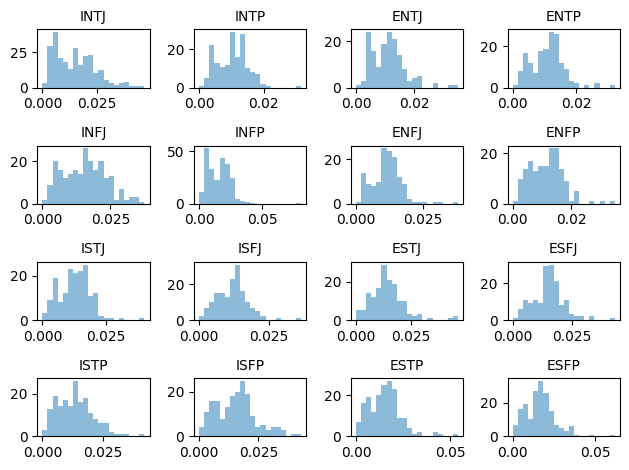

In [89]:
# plot scores distribution on types level

print(
    "Average Nr. of sentences per type: ", 
    type_scored_sentences.apply(len).mean())

i = 1
for t in type_scored_sentences.keys():
    plt.subplot(4, 4, i)
    plt.hist(
        [score for (_, score) in type_scored_sentences[t]],
        bins=20, 
        alpha=0.5, 
        label=t)
    plt.title(t, fontsize=10)
    plt.tight_layout()
    i += 1

del i



In [92]:
def summarize_by_treshold(sentences: List[Tuple[str, float]], treshold: float, sep: str=" ") -> str:
    """Select only sentences with a score above a certain treshold
    and merge them in an unique summary"""

    summary = ""
    for sentence, score in sentences:
        if score > treshold:
            summary += sentence + sep

    return summary

s = summarize_by_treshold(type_scored_sentences['INTJ'], 0.03, sep="\n")
print(s)


# with open('INTJ_summary_bad_example.txt', 'w') as f:
#     f.write(s)

But ever-skeptical Architects prefer to make their own discoveries.
Architects want to be successful, not just inventive.
Informed – Few personality types are as devoted as Architects to forming rational, evidence-based opinions.
Creative and self-motivated, Architects strive to do things their own way.
Dismissive of Emotions – For Architects, rationality is king.
Architects seek strong, meaningful relationships.
But this doesn’t mean that Architects are antisocial or friendless.
Architects care about depth and quality.
And for Architects who choose to have children, few challenges may be as meaningful as parenthood.
People with this personality type brim with creative, out-of-the-box ideas.
The truth is that Architects can excel in just about any role.
And if any personality type has high standards for themselves, it’s almost certainly Architects.
And in many ways, Architects are exactly that.
But some personality types may find it a challenge to work with Architects.
Architect Subord

In [96]:
s = summarize_by_treshold(type_scored_sentences['INTP'], 0.015, sep="\n")
print(s)

Logicians pride themselves on their inventiveness and creativity, their unique perspective and vigorous intellect.
Logicians excel in analyzing these connections, seeing how seemingly unrelated factors tie in with each other in ways that bewilder most other personality types.
This is especially true with people – Logicians are quite shy in social settings.
Condescending – Attempts at connecting with others are often worse than Logicians’ withdrawal.
The ultimate insult comes as Logicians give up with a dismissive “never mind”.
As their relationships progress, Logicians’ daily needs prove remarkably simple.
When these conflicts do arise and are inescapable, Logicians will do their best to find a logical solution.
After all, they need to afford Logicians the same benefit, and meet them halfway with logic and simplicity as well.
Other Analyst personalities are a natural fit for Logicians, who share their passion for new ideas, riddles and solutions.
Logicians’ parenting style affords a gr

## Clustering and grouping of MBTI types

> Can we group the MBTI types in clusters? Is there any similarity emerging from the descriptions?

**Tools and techniques**: *clustering, PCA*

In [16]:
# Join tokens in a text that can be vectorized
df_types["TokenOnlyText"] = df_types["Tokens"].apply(lambda x: " ".join(x))
df_types.head(1)

,FullText,Tokens,FreqDict,Sentences,SentencesScores,Summaries1,Summaries2,TfIdfDict,TfIdfSentencesScores,SummariesTfIdf1,SummariesTfIdf2,TokenOnlyText
INTJ,"Imaginative and strategic thinkers, with a pla...","[imaginative, strategic, thinker, plan, person...","{'imaginative': 2, 'strategic': 2, 'thinker': ...","[Imaginative and strategic thinkers, with a pl...","[19.5, 20.11111111111111, 4.4, 5.3333333333333...",[As one of the rarest personality types – and ...,"[Dismissive of Emotions – For Architects, rati...","{'imaginative': 0.01176386470450463, 'strategi...","[0.07595696705255923, 0.06540384649204929, 0.0...",[Finding a Better Way\n\nArchitects question e...,[And if any personality type has high standard...,imaginative strategic thinker plan person intr...


In [17]:
from typing import Tuple


def make_clustering(
        df: pd.DataFrame, k: int, n_keywords: int, 
        ngram_range: Tuple[int, int]=(1,1), min_df: int=1, max_df: float=1.0):
    """
    Make clustering of the texts in the dataframe df.

    Parameters:
    - df: dataframe with a column "TokenOnlyText" with the text to cluster
    - k: number of clusters
    - n_keywords: number of keywords to extract for each cluster
    - ngram_range: range of ngrams to use for the vectorization
    - min_df: minimum document frequency for a term to be considered
    - max_df: maximum document frequency for a term to be considered

    Returns:
    a dataframe with a column "Cluster" with the cluster for each text
    
    Prints also a summary of the clusters with the top keywords
    """

    # vectorize the text using tf-idf 
    # filtering by document frequency
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, min_df=min_df, max_df=max_df)

    # generate sparse matrix
    X = vectorizer.fit_transform(df["TokenOnlyText"])

    # apply K-means
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(X)

    clusters = kmeans.labels_.tolist()

    df_types["Cluster"] = clusters

    df2 = pd.DataFrame(X.todense())
    df2["Cluster"] = clusters
    cluster_values = df2.groupby("Cluster").mean()
    
    # get tf-idf terms 
    terms = vectorizer.get_feature_names_out()
    
    for i,r in cluster_values.iterrows():
        print('\nCluster {}: '.format(i))
        print(df[df["Cluster"] == i].index.values)
        print(','.join([terms[t] for t in np.argsort(r)[-n_keywords:]]))

    return df, X



In [18]:
df_types, X = make_clustering(df_types, 4, 10, ngram_range=(1,1), min_df=4, max_df=10)


Cluster 0: 
['ENTJ' 'ISTJ' 'ISFJ' 'ESTJ' 'ESFJ']
standard,stable,community,duty,established,tradition,authority,family,respect,dedication

Cluster 1: 
['INTP' 'ENTP' 'ENFJ' 'ENFP']
theory,conversation,analyst,genuine,idealism,logic,insight,chance,debate,intellectual

Cluster 2: 
['INTJ' 'INFJ' 'INFP']
inner,independence,ideal,idealism,generally,perfect,fortunately,insight,said,employee

Cluster 3: 
['ISTP' 'ISFP' 'ESTP' 'ESFP']
appreciated,hobby,excitement,spontaneity,charming,style,exciting,planning,relaxed,fun


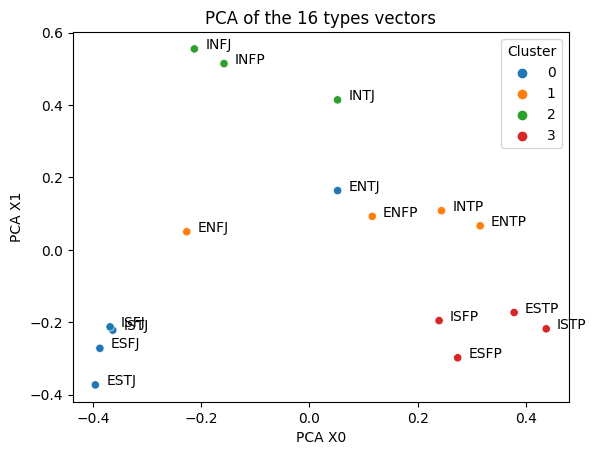

In [19]:
pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(X.toarray())

df_types["PCA_X0"] = pca_vecs[:,0]
df_types["PCA_X1"] = pca_vecs[:,1]

sns.scatterplot(data=df_types, x="PCA_X0", y="PCA_X1", hue="Cluster", palette="tab10")

plt.title("PCA of the 16 types vectors")
plt.xlabel("PCA X0")
plt.ylabel("PCA X1")

def label_point(x, y, val, ax):
    a = pd.DataFrame({'x': x, 'y': y, 'val': val})
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(df_types["PCA_X0"], df_types["PCA_X1"], df_types.index, plt.gca())

plt.show()



## Topic labeling on MBTI types

> Which are the main topics of each found cluster? And of each MBTI type? And of the whole dataset? 

**Tools and techniques**: *topic modeling (LDA)*

In [20]:
types.columns

Index(['Introduction', 'Strengths and Weaknesses', 'Romantic Relationships',
       'Friendships', 'Parenthood', 'Career Paths', 'Workplace Habits',
       'Conclusion', 'Celebrities', 'Description', 'Nickname', 'Definition',
       'E', 'I', 'N', 'S', 'T', 'F', 'J', 'P'],
      dtype='object')

In [21]:
# take as documents all the paragraph of a type
def get_type_paragraphs(df, type_name: str, paragraphs: list = [
        "Introduction", 
        "Strengths and Weaknesses", 
        "Romantic Relationships", 
        "Friendships", 
        "Parenthood", 
        "Career Paths",
        "Workplace Habits",
        "Conclusion", 
        "Description",
    ]) -> List[str]:

    return [df.loc[type_name, :][p] for p in paragraphs]

# get the paragraphs for each type
paragraphs = [p for t in types.index for p in get_type_paragraphs(types, t)]


In [22]:
# extract tokens 
all_tokens = [preprocessing(p, lemmatizer, 1, other_stopwords) for p in paragraphs]

# make a dictionary
all_tokens_dict = gensim.corpora.Dictionary(all_tokens)

# convert tokenized documents into a document-term matrix
corpus = [all_tokens_dict.doc2bow(tokens) for tokens in all_tokens]


In [23]:
# generate LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=5, id2word=all_tokens_dict, passes=20)

for t in lda_model.print_topics(num_words=10):
    print(t)

(0, '0.022*"protagonist" + 0.013*"child" + 0.009*"people" + 0.009*"personality" + 0.007*"parent" + 0.007*"type" + 0.006*"make" + 0.006*"often" + 0.006*"executive" + 0.006*"take"')
(1, '0.021*"need" + 0.012*"personality" + 0.012*"type" + 0.010*"go" + 0.009*"challenge" + 0.009*"many" + 0.009*"learn" + 0.008*"may" + 0.008*"potential" + 0.007*"personal"')
(2, '0.019*"personality" + 0.017*"advocate" + 0.017*"people" + 0.013*"type" + 0.009*"may" + 0.009*"friend" + 0.007*"entrepreneur" + 0.007*"others" + 0.006*"make" + 0.006*"defender"')
(3, '0.018*"personality" + 0.014*"people" + 0.012*"type" + 0.008*"partner" + 0.008*"make" + 0.007*"relationship" + 0.007*"thing" + 0.007*"need" + 0.006*"logistician" + 0.006*"entertainer"')
(4, '0.019*"personality" + 0.015*"child" + 0.013*"type" + 0.012*"people" + 0.010*"architect" + 0.008*"commander" + 0.008*"logician" + 0.007*"executive" + 0.007*"may" + 0.006*"make"')
